# Markov Chains

*Davide Gerosa (Milano-Bicocca)*


This course is based on previous work by many people. See [here]((https://github.com/dgerosa/machinelearning4physics_bicocca_2024) for credits.

---

Today I'll talk less and you'll code more...

In [42]:
import numpy as np
import pylab as plt
from scipy import stats

Markov Chains are one of the two ingredients in MCMC (Monte Carlo Markov Chains), which is the a major sampling tecnique. Really, MCMCs are everywhere!


Evaluating a posterior faithfully can be very hard! **The key ideas behing MCMC approaches are**: 
- We give up. We don't even try to scan the posterior and compute it, but the goal becomes to *sample* it. Once I have samples, I can then reconstruct the posterior with a suitable density estimation scheme. 
- We give up again. We don't even try to write a deterministic algorithm but rather rely on random numbers. MCMCs are a flavour of *stochastic sampling*. 

### Why Monte Carlo?

The name derives from the name of an administrative area of the Principality of Monaco ([Monte Carlo](https://www.wikiwand.com/en/Monte_Carlo)) known for high-stakes casinos and gambling. Gambling and random sampling go hand in hand together.

![](https://www.thomascook.com/.imaging/mte/thomascook-theme/og-image/dam/legacy/heros/citybreaks/monte-carlo/montecarlohero.jpg/jcr:content/montecarlohero.jpg)


## Monte Carlo integration

Monte Carlo integration is an absolute crucial notion in modern statistics (modern because it relies on generating a large number of data points, which has been made possible by computers). Suppose you have very a complicated integral to solve (any integral, it's completely generic!). You write down the integrand as a product of $f(x)$ and $p(x)$ such that $\int p(x)=1$ (this is not restrictive at all! See below). My nasty integral is

$$\int f(x) p(x) dx$$


Provided one can **evaluate** $f(x)$ and **sample** $p(x)$, then


$$\int f(x) p(x) dx \approx \frac{1}{N}\sum_{i=1}^N f(x_i) $$

where $x_i$ are samples drawn from $p$. 

Take a deep breath and appreciate how poerful this is. It works in any number of dimensions!!!

### Example 1. A messy integral.

Ok try to integrate this crazy thing I just came up with. Pen and paper? Good luck.
    
$$\int_{0.3}^4 dx \frac{\exp(x) \sqrt{4x+3}  \log(x^6)}{\tanh(x)}$$

Pen and paper? Good luck. With a computer? Easy peasy!

First, I divide and multiply by $4-0.3$. This is because 1/(4-0.3) is the uniform distribution $p(x)$ for x between 0.3 and 4.

$$ (4-0.3) \times \int_{0.3}^{4} \frac{dx}{(4-0.3)} \frac{\exp(x) \sqrt{4x+3} * \log(x^6)}{\tanh(x)}$$

Now I have $p(x)=\frac{1}{4-0.3}$ and $f(x) = \frac{\exp(x) \sqrt{4x+3} * \log(x^6)}{\tanh(x)}$. All I need to do is generate numbers from $p$, put them into $f$, and sum the results.

In [43]:


xmax= 4
xmin=0.3

xi=np.random.uniform(xmin,xmax, 100000)

def fun(x):
    return np.exp(x)*(4*x+3)**0.5 * np.log(x**6)/np.tanh(x)

integral = (xmax-xmin) * np.mean(fun(xi))

integral


1387.1783302168203

Check the analytic result:
https://www.wolframalpha.com/input/?i=integrate+from+0.3+to+4+exp%28x%29+sqrt%284x%2B3%29+*+ln%28x%5E6%29+%2Ftanh%28x%29

Run the cell again. And again.  The result is different. We have an *estimator* of our integral. Because of the central limit theorem, this estimator is unbiased. 

Of course, the larger the number of points the higher the accuracy. How do you think the error will scale? We've see this already...

[]

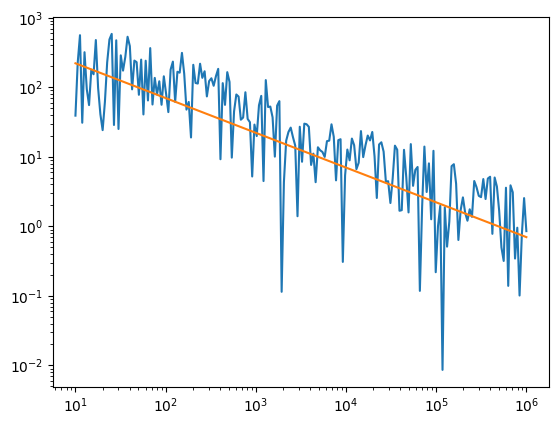

In [44]:
Ns= np.geomspace(10,1e6,200)
truevalue=1391.76


residuals=[]
for N in Ns:
    xi=np.random.uniform(xmin,xmax, int(N))
    integral=((xmax-xmin) * np.mean(fun(xi)))
    residuals.append(np.abs(integral-truevalue))
    
plt.plot(Ns,residuals)

plt.plot(Ns,700*Ns**(-0.5)) #The number 700 is arbitray, only the slope is important here!

plt.loglog()

The error scales as $1/\sqrt{N}$! Shouldn't be a big surprise, that's just the error on the mean we've seen a few weeks ago.

### Quick, on-the-fly exercise to make sure you're understanding what's going on.

Using Monte Carlo integration, check that

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = 2\sigma^4 .$$

How many draws does it take to get the error down to 1 part in a thousand?


### Example 2 compute $\pi$.

You might have seen this already, but here it is.

- You have forgotten the value of $\pi$, but you know the formula for the area of a square and how to draw a circle. 
- We can use the information that we *do* know to numerically compute $\pi$.

1. We start by drawing a square and circumscribing a circle in it (actually it suffices to just do a quarter of a circle and scale accordingly).
2. We put down random points within the square and note which ones land in the circle.
3. The ratio of random points in the circle to the number of random points drawn is related to the area of our circle, allowing us to calculate $\pi$.
4. Using more random points yields more precise estimates of the area.

Estimate of pi is 3.144 for 1000 draws with fractional error 0.000766282161837951.


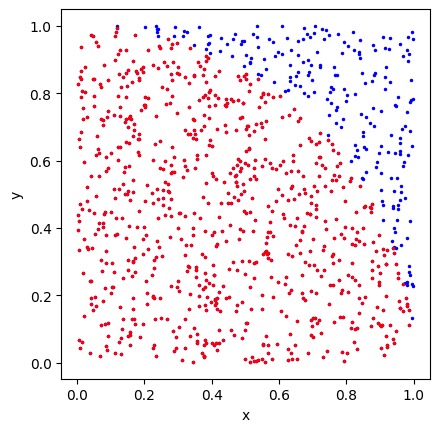

In [45]:
# Lay down M random points.  Tally how many are within a unit circle.
M = 1000
x = stats.uniform(0,1).rvs(M) # M random draws between 0 and 1
y = stats.uniform(0,1).rvs(M) # M random draws between 0 and 1

r2 = x**2+y**2 # equation for radius of cirle in x,y

fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))

# Plot points in square
plt.plot(x, y, '.', 
         markersize=3, c='blue') 

# Plot points also in circle
plt.plot(x[r2 < 1], y[r2 < 1], '.', 
         markersize=3, c='red') 

#ax.axis([0, 1, 0, 1], aspect='equal');
plt.xlabel('x')
plt.ylabel('y')
    
# A_square = d^2, Acircle = pi*d^2
piEst = 4 * np.sum(r2 < 1) / M # pi = 4A/d^2, where A is d^2 times the ratio of points "in" to total points

print("Estimate of pi is {0} for {1} draws with fractional error {2}.".format(piEst, M, 
                                                                              np.abs((np.pi-piEst)/np.pi)))

See also [this Khan Academy simulation](https://www.khanacademy.org/computer-programming/monte-carlo-finding-the-value-of-pi/6530004791197696/embedded?embed=yes&article=yes&editor=no&buttons=no&author=no&autoStart=yes&width=610&height=420).



## Monte Carlo Methods & Markov Chains <a class="anchor" id="one"></a>

### Motivation

Consider the parameter estimation problem we've seen last time.

It was easy to *numerically* scan the posterior, find its maximum, and understand what was going on. That was was only a $1$D problem! Even if you make it 2D, with $100$ grid points per coordinate it was only $10^4$ values. 

However, **what about high parameter dimensions?** Modern applications span hundreds or maybe thousands of dimensions!
- Even in a case of rather simple $5$D problem, we'd have $10^{10}$ values! And often we work with models of much higer dimensionality (it can be thousands!). **Brute-force grid methods are not feasible beyond a few dimensions**, and even then can be waste of time. 
- You could **simply randomly sample the grid at every point**, and try to find the minimum based on that. But that can also be quite time consuming, and you will spend a lot of time in regions of parameter space that yields small likelihood.

A better way is to adopt a ***Markov-Chain Monte Carlo (MCMC)***. MCMC gives us a way to make this problem computationally tractable by sampling the full multi-dimensional parameter space, in a way that builds up the most sample density in regions that are closest to the maximum probability. Then, you can post-process the “chain” of points to infer the posterior distribution and uncertainty regions.

Ivezic, Figure 5.22 shows a 2D problem done with a both a posterior scan and a Markov Chain Monte Carlo algorithm. The solid lines are from the MCMC estimate with 10,000 sample points. Not exact (it's stochastic sampling!) but, much like the integral above, we can understand our errors very well.

![Ivezic, Figure 5.10](http://www.astroml.org/_images/fig_cauchy_mcmc_1.png)


But one thing at the time.

## What is a Markov Chain?

A Markov Chain is defined as 

> a sequence of random variables (or *chain*) where a parameter depends *only* on the preceding value. Such processes are "memoryless".  
 
That's it. Simple.
 
 
Mathematically, we have

$$p(\theta_{i+1}|\theta_i, \theta_{i-1}, \theta_{i-2}, \cdots) = p(\theta_{i+1}|\theta_i).$$

For  equilibrium, or a stationary distribution of positions, it is necessary that the transition probability is symmetric:

$$    p(\theta_{i+1}|\,\theta_i) = p(\theta_i |\, \theta_{i+1}). $$

This is called the ***principle of detailed balance*** or reversibility condition (i.e. the probability of a jump between two points does not depend on the direction of the jump).

For instance, the stock market has phases of growing prices (bull), dreasing prices (bear) and recession. This would a a Marov Chain model:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Finance_Markov_chain_example_state_space.svg/400px-Finance_Markov_chain_example_state_space.svg.png)

A great example of a physical process well desribed by a Markow Chain is that of gas diffusion: two boxes, and want to know then nubmer of molecules in each box at any given time. These are called Ehrenfest chains
- https://www.randomservices.org/random/markov/Ehrenfest.html
- https://phys.libretexts.org/Bookshelves/Mathematical_Physics_and_Pedagogy/Computational_Physics_(Chong)/12%3A_Markov_Chains/12.03%3A_The_Ehrenfest_Model


![](https://www.randomservices.org/random/markov/Ehrenfest.png)

# Exam exercise!

### Planning a telescope observation

Let's build your first Markov Chain! 

You are a real astronomer (not a theory guy like me) and are planning an expensive observational campaign. You want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:

$$p({\rm clear \; tomorrow} \, |\,  {\rm cloudy \; today}) = 0.5,$$

which means that

$$p({\rm cloudy \; tomorrow} \, |\, {\rm cloudy \; today}) = 0.5.$$

We also have

$$p({\rm cloudy \; tomorrow} \, |\, {\rm clear \; today}) = 0.1,$$

which means that

$$p({\rm clear \; tomorrow} \, |\, {\rm clear \; today}) = 0.9.$$


- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree. 
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at

$$p({\rm clear}) = 0.83,$$

and 

$$p({\rm cloudy}) = 0.17.$$

You get the same answer for day $N$ as day $N+1$ and it doesn't matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are, indeed, a **MARKOV CHAIN**.

Here is an illustration of this process from an article in [towarddatascience.com](https://towardsdatascience.com/introduction-to-markov-chains-50da3645a50d).

![image.png](https://miro.medium.com/max/416/1*frksGjINf5oTjx7WL81U3w.png)

#### Tasks

- Start off on a cloud day. 
- Implement your weather forecast based on the above probabilities
- Run your simulator for N days (with $N\gtrsim 10^4$)
- Prepare a plot with the number of days on the x axis and the cumulative number of, say, sunny days over the number of days so far on the y axis. This is called a **trace-plot**, showing how our estimate of $p(\mathrm{clear})$ evolves as the chain samples.  
- Prepare a histogram of the above plot. This reveals the distribution of $p(\mathrm{clear})$.
- Use a summary statistics to determine the most likely value and an error on our estimate.

**Important:** 
- In MCMC the process must be **stationary** which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.  
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
- So, there is a **burn-in** phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, but ***you should always start with a traceplot of your samples!***


#### Tasks

- In the above example, experiment with chopping off different numbers of initial points as burn-in.
- Repeat everything you've done but this time use the stock-market diagram with three phases as shown above. If you've written your code well, you should need small modifications.

## Balls in many dimensions

Do your know the volume of a sphere in N dimensions. It's fun!

Start from the code above we wrote to estimate pi, and generalize it to an artibrary number of dimensions. So for instance N=3 will give you the volume of a sphere, etc etc. 

That will be you Monte Carlo estimate. You can compare your estimate with the [analytic reusult](https://en.wikipedia.org/wiki/Volume_of_an_n-ball)

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/80ca960dcc289606363b3ca5560d921b7c6fea96)

where $\Gamma$ is the Gamma function (conceptually a generalization of factorials to non-integer numbers). 

Explore! Write a code for a generic N, then run it, increasing N as much as you can. How many samples do you need for a decent accuracy?

As you will see, the $N\to\infty$ limit is very (very!) surprising.